In [14]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [15]:
import os
import cv2
import numpy as np
import pandas as pd

# #Change this value based on your preferences
train_dir = "./jellyfish/Train_Test_Valid/Train"
train_dataframe = pd.DataFrame(columns=["path", "class"])

In [16]:
for class_name in os.listdir(train_dir):
  class_dir = os.path.join(train_dir, class_name)
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    train_dataframe.loc[len(train_dataframe.index)] = [image_path, class_name]

In [17]:
train_dataframe

,path,class
0,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
1,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
2,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
3,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
4,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
...,...,...
895,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
896,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
897,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
898,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish


In [18]:
xdim = 224
ydim = 224

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

main_datagen=ImageDataGenerator(rescale=1./255., # 정규화 
                               horizontal_flip = True, # 수평으로 뒤집기
                                vertical_flip = True, # 수직으로 뒤집기 
                               rotation_range = 5) # +5도 또는 -5도 범위 내에서 회전 

In [20]:
# 데이터프레임의 "path"라는 열의 데이터를 NumPy 배열로 변환하여 X에 담기 
X = np.array(train_dataframe["path"])

In [21]:
wandb.login(key = "c4e33984a0f1d0c7e209f455add7b4da4718e070")

#import os
#import wandb

#wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [22]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    #"method": "grid",  # Grid search
    "batch_size": {"values": [16, 32]},
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.01
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

def train_with_kfold():
    default_config = {
        "learning_rate": 0.005,
        "epoch": 5,
        "batch_size": 32
    }

    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    
    cvScores = []
    labels = list(train_dataframe["class"].unique())

    all_fold_histories = []  # 각 폴드별 기록 저장
    train_val_diffs = []  # 훈련-검증 정확도 차이를 저장
    
    
    # W&B 실행 초기화 (Run 이름에서 폴드 정보 제외)
    wandb.init(
        config=default_config,
        project="WandB_with_kfold_used_by_Jindeok_revised_again",
        name=f"CrossValidation_{wandb.util.generate_id()}",
        reinit=True
    )
    config = wandb.config
    
    
    fold = 1
    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        print(f"Fold: {fold} ==================================================================")

        train_data = X[train_index]
        test_data = X[test_index]
        train_dataframe_inside = train_dataframe.loc[train_dataframe["path"].isin(list(train_data))]
        validation_dataframe = train_dataframe.loc[train_dataframe["path"].isin(list(test_data))]

        if train_dataframe_inside.empty or validation_dataframe.empty:
            print(f"Empty data detected in fold {fold}. Skipping.")
            continue

        train_generator = main_datagen.flow_from_dataframe(
            dataframe=train_dataframe_inside,
            x_col="path",
            y_col="class",
            class_mode="categorical",
            classes=labels,
            target_size=(xdim, ydim),
            color_mode="rgb",
            batch_size=32
        )

        validation_generator = main_datagen.flow_from_dataframe(
            dataframe=validation_dataframe,
            x_col="path",
            y_col="class",
            class_mode="categorical",
            classes=labels,
            target_size=(xdim, ydim),
            color_mode="rgb",
            batch_size=32
        )

       

        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(xdim, ydim, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(len(labels), activation='softmax')
        ])

    
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )

        model_history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=config.epoch,
            verbose=1,
            callbacks=[early_stopping]
        )

        # 각 폴드의 기록 저장
        all_fold_histories.append(model_history.history)
        
        
        # 훈련-검증 성능 차이 저장
        final_train_accuracy = model_history.history["accuracy"][-1]
        final_val_accuracy = model_history.history["val_accuracy"][-1]
        train_val_diffs.append(final_train_accuracy - final_val_accuracy)
        
        
        
        
        
        # 폴드별 성능 로그
        scores = model.evaluate(validation_generator)
        cvScores.append(scores[1] * 100)
        print(f"Validation Accuracy for Fold {fold}: {scores[1] * 100:.2f}%")

        
        
        wandb.log({
            "fold": fold,
            "final_validation_accuracy": scores[1] * 100,
            "fold_train_accuracy": final_train_accuracy,
            "fold_val_accuracy": final_val_accuracy,
            "accuracy_diff": final_train_accuracy - final_val_accuracy
        })
        
        
        
        #wandb.log({
            #"fold": fold,
            #"final_validation_accuracy": scores[1] * 100,
            #"fold_train_accuracy": model_history.history["accuracy"][-1],
            #"fold_val_accuracy": model_history.history["val_accuracy"][-1]
        #})
        
        fold += 1 
        
        
    # 모든 폴드의 정확도 시각화
    plt.figure(figsize=(12, 8))
    for fold, history in enumerate(all_fold_histories, start=1):
        plt.plot(history['val_accuracy'], label=f'Fold {fold} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Across Folds')
    plt.legend()
    plt.show()
    
    
    
    # 훈련-검증 성능 차이 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(train_val_diffs) + 1), train_val_diffs, color="orange", edgecolor="black")
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.xlabel("Fold")
    plt.ylabel("Accuracy Difference (Train - Validation)")
    plt.title("Train vs. Validation Accuracy Difference per Fold")
    plt.xticks(range(1, len(train_val_diffs) + 1), labels=[f"Fold {i}" for i in range(1, len(train_val_diffs) + 1)])
    plt.show()
    
    
    
    
    # 평균 및 표준 편차 계산 및 출력
    mean_accuracy = np.mean(cvScores)
    std_accuracy = np.std(cvScores)
    print(f"Cross-validation scores: {cvScores}")
    print(f"Mean Accuracy: {mean_accuracy:.2f}%")
    print(f"Accuracy Standard Deviation: {std_accuracy:.2f}%")

    # 전체 결과 W&B 로그 추가
    wandb.log({
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy
    })
    
    wandb.finish()
    

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('batch_size' was unexpected)


Create sweep with ID: iu4d3d80
Sweep URL: https://wandb.ai/wisdom-jihyekim-aiffel/WandB_with_kfold_used_by_Jindeok_revised_again/sweeps/iu4d3d80


wandb: Agent Starting Run: jctcv7zf with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.008175513825608804
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/6
23/23 [==============================] - 11s 441ms/step - loss: 2.2376 - accuracy: 0.1764 - val_loss: 1.8213 - val_accuracy: 0.1667
Epoch 2/6
23/23 [==============================] - 10s 424ms/step - loss: 1.8137 - accuracy: 0.1625 - val_loss: 1.7917 - val_accuracy: 0.1722
Epoch 3/6
23/23 [==============================] - 10s 418ms/step - loss: 1.7925 - accuracy: 0.1514 - val_loss: 1.7932 - val_accuracy: 0.1389
Epoch 4/6
23/23 [==============================] - 10s 422ms/step - loss: 1.7921 - accuracy: 0.1736 - val_loss: 1.7933 - val_accuracy: 0.1389
Epoch 5/6
23/23 [==============================] - 10s 423ms/step - loss: 1.7929 - accuracy: 0.1597 - val_loss: 1.7935 - val_accuracy: 0.1389
Epoch 6/6
6/6 [==============================] - 2s 306ms/step - loss: 1.7933 - accuracy: 0.155

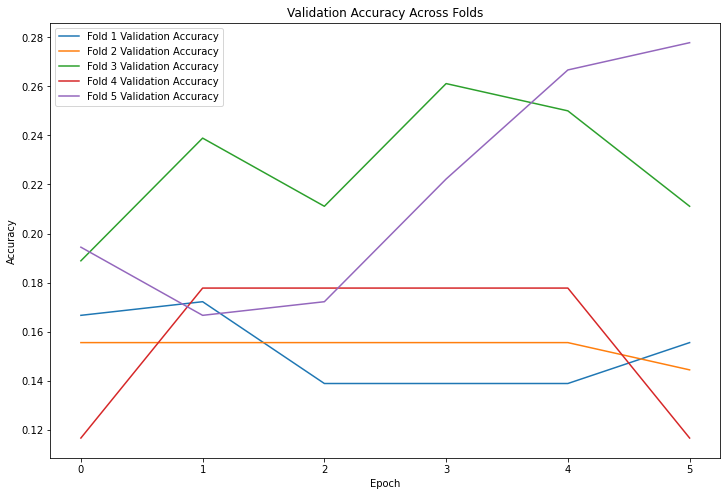

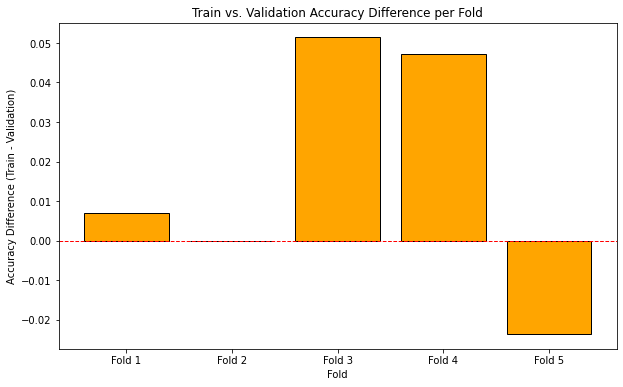

Cross-validation scores: [15.555556118488312, 14.444445073604584, 23.888888955116272, 11.666666716337204, 27.77777910232544]
Mean Accuracy: 18.67%
Accuracy Standard Deviation: 6.11%


accuracy_diff,▄▃██▁
final_validation_accuracy,▃▂▆▁█
fold,▁▃▅▆█
fold_train_accuracy,▂▁█▂█
fold_val_accuracy,▃▂▅▁█
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,-0.02361
final_validation_accuracy,27.77778
fold,5
fold_train_accuracy,0.25417


wandb: Agent Starting Run: il3lf6os with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.005755772577147411
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/7
23/23 [==============================] - 11s 447ms/step - loss: 2.2987 - accuracy: 0.2139 - val_loss: 1.8618 - val_accuracy: 0.1944
Epoch 2/7
23/23 [==============================] - 10s 420ms/step - loss: 1.7588 - accuracy: 0.2083 - val_loss: 1.7340 - val_accuracy: 0.2444
Epoch 3/7
23/23 [==============================] - 10s 430ms/step - loss: 1.7151 - accuracy: 0.2375 - val_loss: 1.6735 - val_accuracy: 0.2722
Epoch 4/7
23/23 [==============================] - 10s 420ms/step - loss: 1.6459 - accuracy: 0.2833 - val_loss: 1.5997 - val_accuracy: 0.3500
Epoch 5/7
23/23 [==============================] - 10s 419ms/step - loss: 1.5189 - accuracy: 0.3722 - val_loss: 1.4862 - val_accuracy: 0.3778
Epoch 6/7
23/23 [==============================] - 10s 422ms/step - loss: 1.4449 - accuracy: 0.

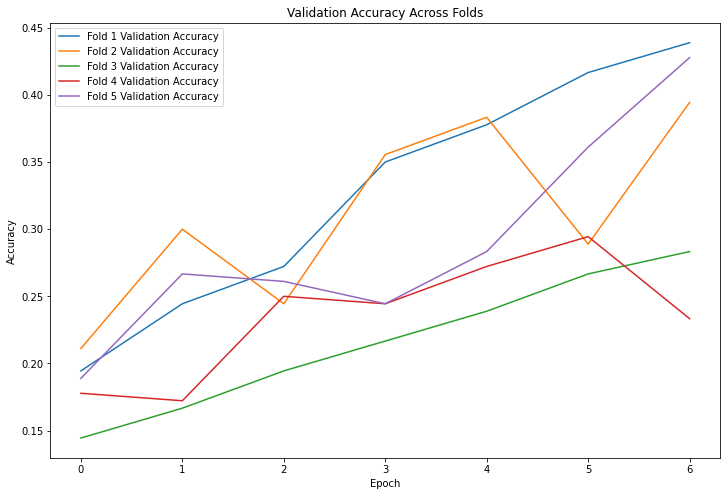

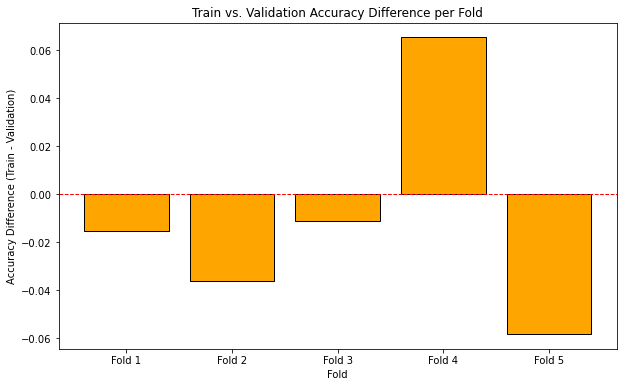

Cross-validation scores: [43.88888776302338, 38.88888955116272, 26.66666805744171, 21.111111342906952, 43.33333373069763]
Mean Accuracy: 34.78%
Accuracy Standard Deviation: 9.23%


accuracy_diff,▃▂▄█▁
final_validation_accuracy,█▆▃▁█
fold,▁▃▅▆█
fold_train_accuracy,█▅▁▂▅
fold_val_accuracy,█▆▃▁█
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,-0.05833
final_validation_accuracy,43.33333
fold,5
fold_train_accuracy,0.36944


wandb: Agent Starting Run: u0wfwgxr with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.007005578273037073
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/10
23/23 [==============================] - 11s 450ms/step - loss: 2.5814 - accuracy: 0.2153 - val_loss: 1.7575 - val_accuracy: 0.1944
Epoch 2/10
23/23 [==============================] - 10s 441ms/step - loss: 1.7328 - accuracy: 0.2458 - val_loss: 1.8146 - val_accuracy: 0.2000
Epoch 3/10
23/23 [==============================] - 10s 424ms/step - loss: 1.7227 - accuracy: 0.2375 - val_loss: 1.7213 - val_accuracy: 0.2667
Epoch 4/10
23/23 [==============================] - 10s 424ms/step - loss: 1.7432 - accuracy: 0.2236 - val_loss: 1.8171 - val_accuracy: 0.2000
Epoch 5/10
23/23 [==============================] - 10s 436ms/step - loss: 1.7632 - accuracy: 0.1861 - val_loss: 1.7583 - val_accuracy: 0.1889
Epoch 6/10
23/23 [==============================] - 10s 424ms/step - loss: 1.7257 - accura

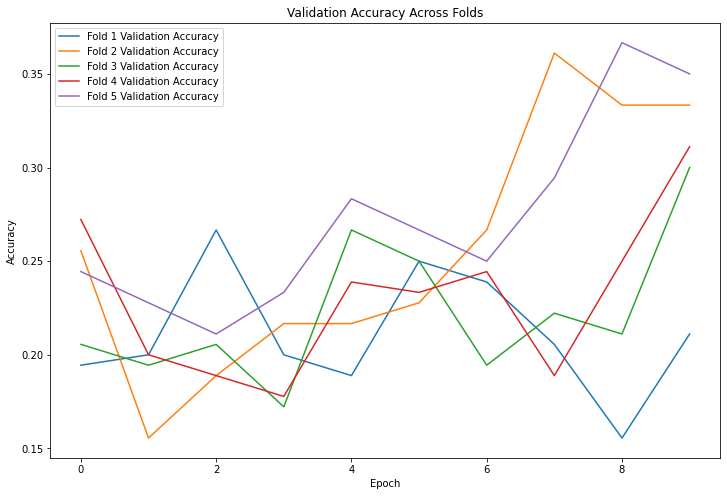

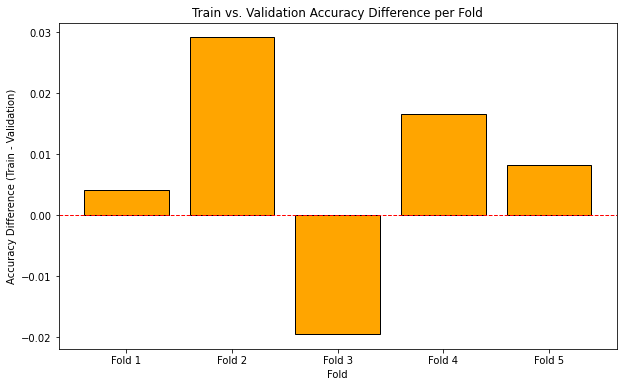

Cross-validation scores: [21.111111342906952, 34.99999940395355, 26.66666805744171, 29.444444179534912, 34.44444537162781]
Mean Accuracy: 29.33%
Accuracy Standard Deviation: 5.16%


accuracy_diff,▄█▁▆▅
final_validation_accuracy,▁█▄▅█
fold,▁▃▅▆█
fold_train_accuracy,▁█▄▆█
fold_val_accuracy,▁▇▅▆█
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.00833
final_validation_accuracy,34.44445
fold,5
fold_train_accuracy,0.35833


wandb: Agent Starting Run: j8mr8chd with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.005511346915412792
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/7
23/23 [==============================] - 11s 450ms/step - loss: 2.3368 - accuracy: 0.2111 - val_loss: 1.7675 - val_accuracy: 0.2556
Epoch 2/7
23/23 [==============================] - 10s 426ms/step - loss: 1.7087 - accuracy: 0.2667 - val_loss: 1.6605 - val_accuracy: 0.2722
Epoch 3/7
23/23 [==============================] - 10s 426ms/step - loss: 1.6177 - accuracy: 0.2917 - val_loss: 1.4783 - val_accuracy: 0.3556
Epoch 4/7
23/23 [==============================] - 10s 423ms/step - loss: 1.4667 - accuracy: 0.4042 - val_loss: 1.5013 - val_accuracy: 0.3722
Epoch 5/7
23/23 [==============================] - 10s 427ms/step - loss: 1.4887 - accuracy: 0.3792 - val_loss: 1.4394 - val_accuracy: 0.4000
Epoch 6/7
23/23 [==============================] - 10s 419ms/step - loss: 1.4763 - accuracy: 0.

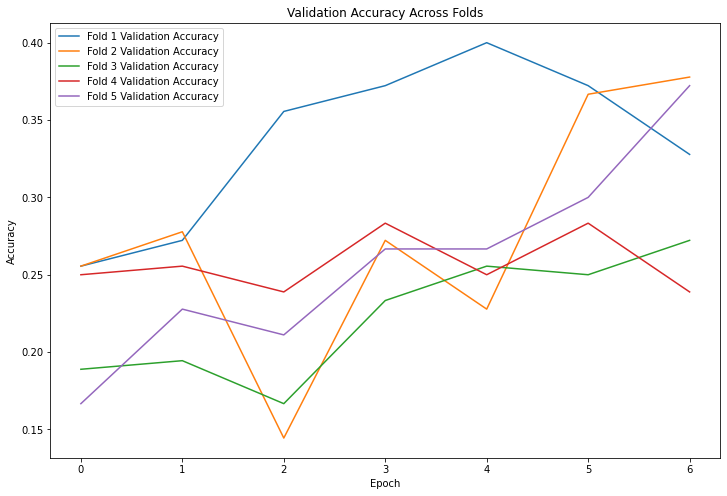

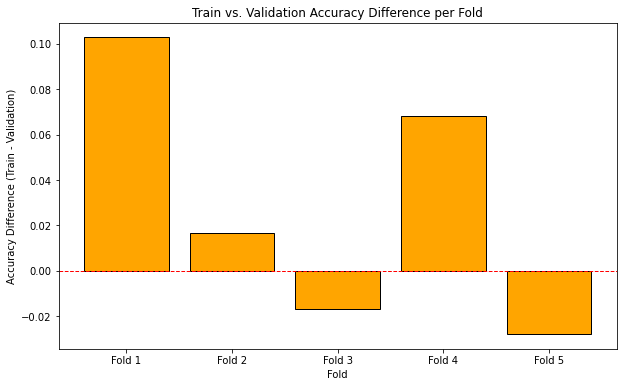

Cross-validation scores: [32.777777314186096, 33.33333432674408, 27.77777910232544, 24.444444477558136, 37.22222149372101]
Mean Accuracy: 31.11%
Accuracy Standard Deviation: 4.49%


accuracy_diff,█▃▂▆▁
final_validation_accuracy,▆▆▃▁█
fold,▁▃▅▆█
fold_train_accuracy,█▇▁▃▅
fold_val_accuracy,▅█▃▁█
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,-0.02778
final_validation_accuracy,37.22222
fold,5
fold_train_accuracy,0.34444


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t8to3gr7 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.004123587945912572
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/7
23/23 [==============================] - 11s 460ms/step - loss: 2.6700 - accuracy: 0.1681 - val_loss: 1.7953 - val_accuracy: 0.1667
Epoch 2/7
23/23 [==============================] - 10s 427ms/step - loss: 1.8131 - accuracy: 0.2236 - val_loss: 1.7129 - val_accuracy: 0.3389
Epoch 3/7
23/23 [==============================] - 10s 441ms/step - loss: 1.6441 - accuracy: 0.2750 - val_loss: 1.6031 - val_accuracy: 0.2833
Epoch 4/7
23/23 [==============================] - 10s 432ms/step - loss: 1.5129 - accuracy: 0.3292 - val_loss: 1.5023 - val_accuracy: 0.3889
Epoch 5/7
23/23 [==============================] - 10s 428ms/step - loss: 1.4653 - accuracy: 0.3819 - val_loss: 1.6222 - val_accuracy: 0.3167
Epoch 6/7
23/23 [==============================] - 10s 428ms/step - loss: 1.4485 - accuracy: 0.

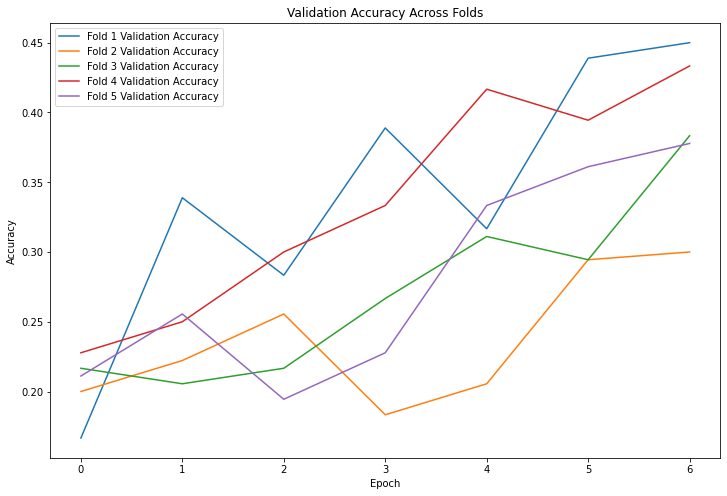

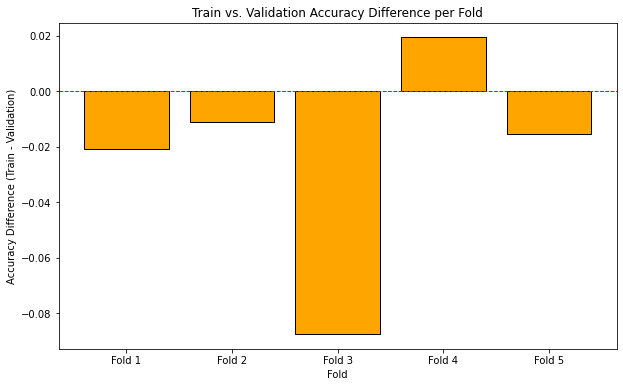

Cross-validation scores: [44.44444477558136, 28.333333134651184, 37.77777850627899, 41.66666567325592, 37.22222149372101]
Mean Accuracy: 37.89%
Accuracy Standard Deviation: 5.46%


accuracy_diff,▅▆▁█▆
final_validation_accuracy,█▁▅▇▅
fold,▁▃▅▆█
fold_train_accuracy,▇▁▁█▄
fold_val_accuracy,█▁▅▇▅
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,-0.01528
final_validation_accuracy,37.22222
fold,5
fold_train_accuracy,0.3625


wandb: Agent Starting Run: 89yzfri7 with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.0049117193911023035
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/8
23/23 [==============================] - 11s 449ms/step - loss: 2.3002 - accuracy: 0.1833 - val_loss: 1.8022 - val_accuracy: 0.2111
Epoch 2/8
23/23 [==============================] - 10s 435ms/step - loss: 1.7787 - accuracy: 0.1931 - val_loss: 1.7494 - val_accuracy: 0.2222
Epoch 3/8
23/23 [==============================] - 10s 434ms/step - loss: 1.7295 - accuracy: 0.2514 - val_loss: 1.7329 - val_accuracy: 0.2056
Epoch 4/8
23/23 [==============================] - 10s 434ms/step - loss: 1.7227 - accuracy: 0.2556 - val_loss: 1.7351 - val_accuracy: 0.2222
Epoch 5/8
23/23 [==============================] - 10s 431ms/step - loss: 1.6811 - accuracy: 0.2569 - val_loss: 1.6752 - val_accuracy: 0.2778
Epoch 6/8
23/23 [==============================] - 10s 430ms/step - loss: 1.6972 - accuracy: 0.

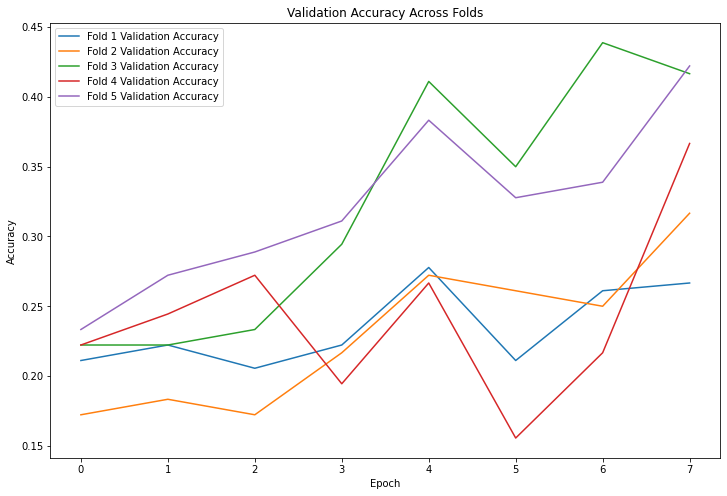

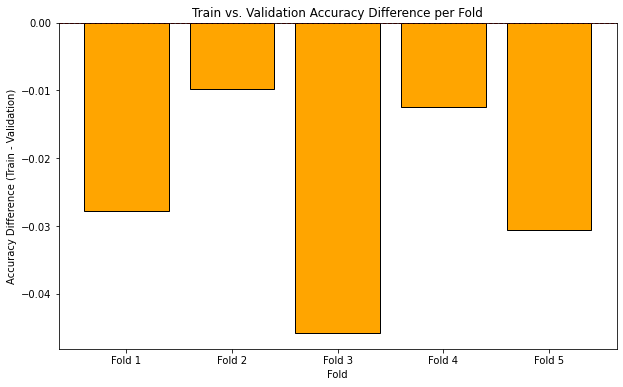

Cross-validation scores: [27.77777910232544, 33.888888359069824, 41.111111640930176, 36.666667461395264, 46.666666865348816]
Mean Accuracy: 37.22%
Accuracy Standard Deviation: 6.40%


accuracy_diff,▄█▁▇▄
final_validation_accuracy,▁▃▆▄█
fold,▁▃▅▆█
fold_train_accuracy,▁▄▇▆█
fold_val_accuracy,▁▃█▅█
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,-0.03056
final_validation_accuracy,46.66667
fold,5
fold_train_accuracy,0.39167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2eo4s6os with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.003210232990037728
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/9
23/23 [==============================] - 11s 443ms/step - loss: 1.9757 - accuracy: 0.1764 - val_loss: 1.8838 - val_accuracy: 0.1778
Epoch 2/9
23/23 [==============================] - 10s 445ms/step - loss: 1.7909 - accuracy: 0.2125 - val_loss: 1.7202 - val_accuracy: 0.2000
Epoch 3/9
23/23 [==============================] - 10s 429ms/step - loss: 1.6349 - accuracy: 0.3056 - val_loss: 1.5900 - val_accuracy: 0.3500
Epoch 4/9
23/23 [==============================] - 10s 431ms/step - loss: 1.5093 - accuracy: 0.3764 - val_loss: 1.6409 - val_accuracy: 0.3778
Epoch 5/9
23/23 [==============================] - 10s 427ms/step - loss: 1.4870 - accuracy: 0.3847 - val_loss: 1.6816 - val_accuracy: 0.2722
Epoch 6/9
23/23 [==============================] - 10s 430ms/step - loss: 1.4746 - accuracy: 0.

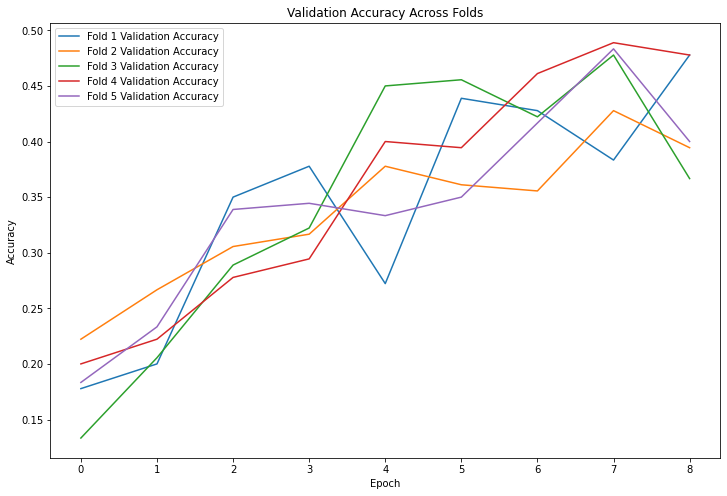

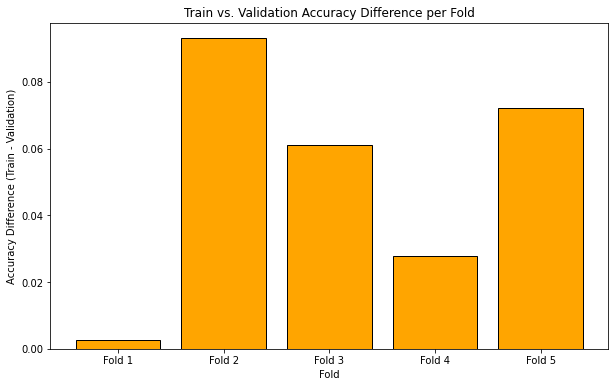

Cross-validation scores: [48.88888895511627, 38.333332538604736, 37.77777850627899, 47.777777910232544, 39.444443583488464]
Mean Accuracy: 42.44%
Accuracy Standard Deviation: 4.85%


accuracy_diff,▁█▆▃▆
final_validation_accuracy,█▁▁▇▂
fold,▁▃▅▆█
fold_train_accuracy,▆▆▁█▅
fold_val_accuracy,█▃▁█▃
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.07222
final_validation_accuracy,39.44444
fold,5
fold_train_accuracy,0.47222


wandb: Agent Starting Run: qvfqq6be with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.004802397179923201
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/9
23/23 [==============================] - 12s 463ms/step - loss: 2.1587 - accuracy: 0.1778 - val_loss: 1.8064 - val_accuracy: 0.1556
Epoch 2/9
23/23 [==============================] - 10s 441ms/step - loss: 1.7701 - accuracy: 0.2542 - val_loss: 1.8143 - val_accuracy: 0.2333
Epoch 3/9
23/23 [==============================] - 10s 448ms/step - loss: 1.6428 - accuracy: 0.3167 - val_loss: 1.5833 - val_accuracy: 0.3611
Epoch 4/9
23/23 [==============================] - 10s 432ms/step - loss: 1.4929 - accuracy: 0.3889 - val_loss: 1.4736 - val_accuracy: 0.3833
Epoch 5/9
23/23 [==============================] - 10s 427ms/step - loss: 1.3700 - accuracy: 0.4444 - val_loss: 1.6325 - val_accuracy: 0.3444
Epoch 6/9
23/23 [==============================] - 10s 427ms/step - loss: 1.3432 - accuracy: 0.

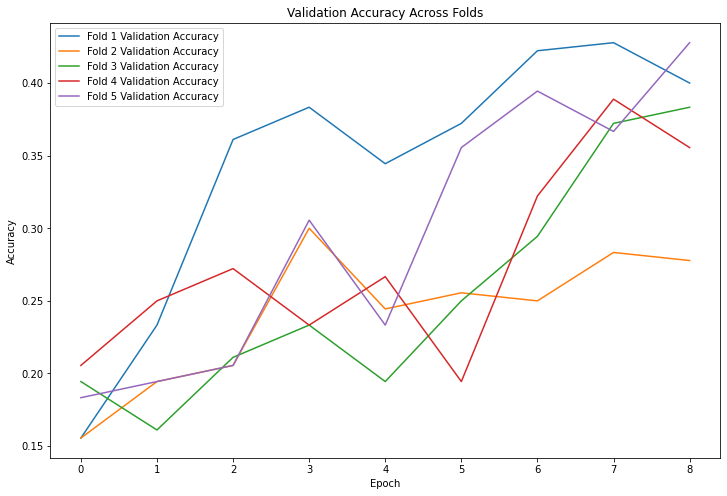

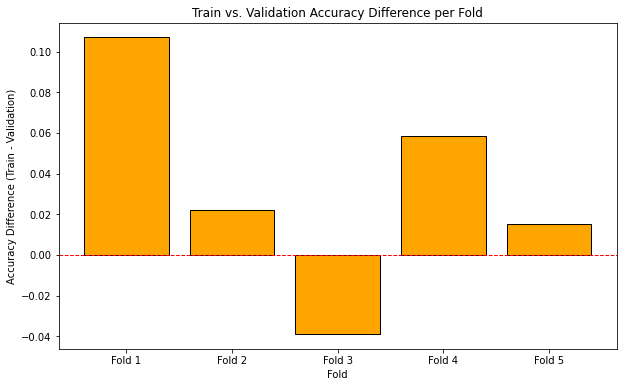

Cross-validation scores: [44.999998807907104, 28.888890147209167, 38.333332538604736, 35.555556416511536, 41.111111640930176]
Mean Accuracy: 37.78%
Accuracy Standard Deviation: 5.43%


accuracy_diff,█▄▁▆▄
final_validation_accuracy,█▁▅▄▆
fold,▁▃▅▆█
fold_train_accuracy,█▁▃▅▆
fold_val_accuracy,▇▁▆▅█
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.01528
final_validation_accuracy,41.11111
fold,5
fold_train_accuracy,0.44306


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bfrzgwi7 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.008790685179587032
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/10
23/23 [==============================] - 12s 463ms/step - loss: 2.8513 - accuracy: 0.1889 - val_loss: 1.7830 - val_accuracy: 0.2222
Epoch 2/10
23/23 [==============================] - 10s 429ms/step - loss: 1.7830 - accuracy: 0.1861 - val_loss: 1.7584 - val_accuracy: 0.2389
Epoch 3/10
23/23 [==============================] - 10s 431ms/step - loss: 1.7526 - accuracy: 0.2222 - val_loss: 1.7524 - val_accuracy: 0.2278
Epoch 4/10
23/23 [==============================] - 10s 428ms/step - loss: 1.7369 - accuracy: 0.2361 - val_loss: 1.7441 - val_accuracy: 0.2500
Epoch 5/10
23/23 [==============================] - 10s 427ms/step - loss: 1.7249 - accuracy: 0.2472 - val_loss: 1.7345 - val_accuracy: 0.2556
Epoch 6/10
23/23 [==============================] - 10s 446ms/step - loss: 1.7208 - accura

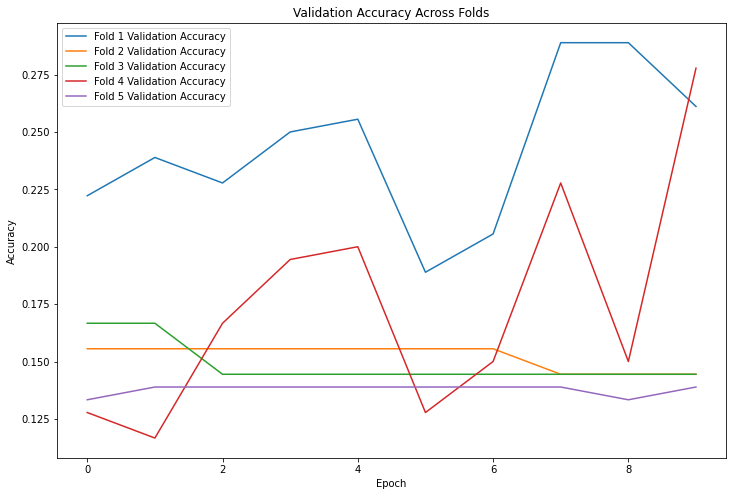

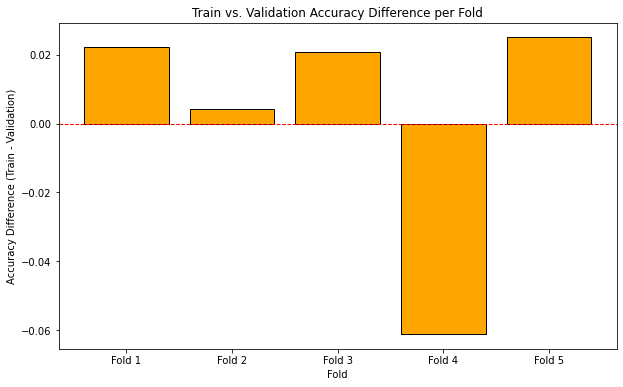

Cross-validation scores: [26.66666805744171, 14.444445073604584, 14.444445073604584, 27.77777910232544, 13.88888955116272]
Mean Accuracy: 19.44%
Accuracy Standard Deviation: 6.36%


accuracy_diff,█▆█▁█
final_validation_accuracy,▇▁▁█▁
fold,▁▃▅▆█
fold_train_accuracy,█▁▂▅▂
fold_val_accuracy,▇▁▁█▁
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.025
final_validation_accuracy,13.88889
fold,5
fold_train_accuracy,0.16389


wandb: Agent Starting Run: g0m8yp9g with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.005714425964115548
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/5
23/23 [==============================] - 11s 460ms/step - loss: 2.4167 - accuracy: 0.1986 - val_loss: 1.8088 - val_accuracy: 0.2056
Epoch 2/5
23/23 [==============================] - 10s 432ms/step - loss: 1.7896 - accuracy: 0.2069 - val_loss: 1.7991 - val_accuracy: 0.2333
Epoch 3/5
23/23 [==============================] - 10s 427ms/step - loss: 1.7035 - accuracy: 0.2486 - val_loss: 1.6994 - val_accuracy: 0.2944
Epoch 4/5
23/23 [==============================] - 10s 434ms/step - loss: 1.6935 - accuracy: 0.2778 - val_loss: 1.6812 - val_accuracy: 0.3222
Epoch 5/5
6/6 [==============================] - 2s 328ms/step - loss: 1.6285 - accuracy: 0.3556
Validation Accuracy for Fold 1: 35.56%
Fold: 2 ==================================================================
Found 720 validated image 

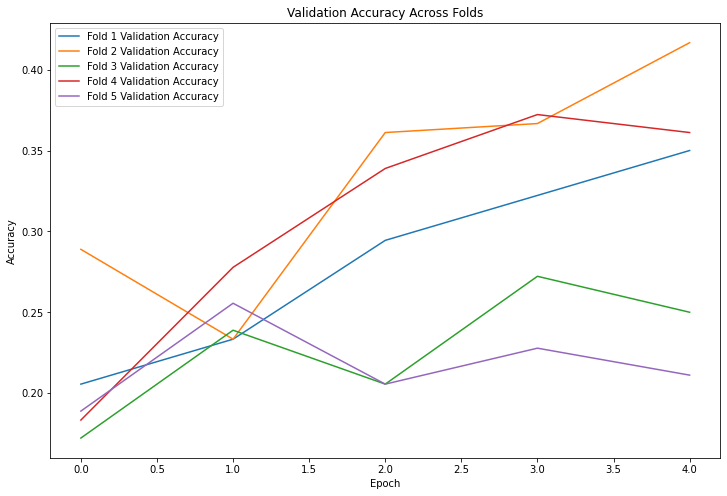

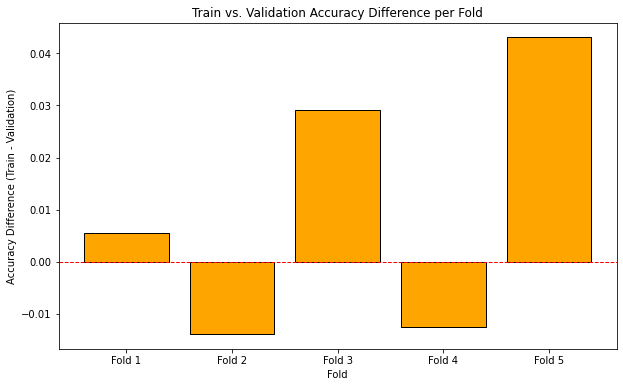

Cross-validation scores: [35.555556416511536, 40.55555462837219, 24.444444477558136, 33.33333432674408, 21.666666865348816]
Mean Accuracy: 31.11%
Accuracy Standard Deviation: 7.04%


accuracy_diff,▃▁▆▁█
final_validation_accuracy,▆█▂▅▁
fold,▁▃▅▆█
fold_train_accuracy,▆█▂▅▁
fold_val_accuracy,▆█▂▆▁
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.04306
final_validation_accuracy,21.66667
fold,5
fold_train_accuracy,0.25417


In [24]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "wisdom-jihyekim-aiffel",
                       project = "WandB_with_kfold_used_by_Jindeok_revised_again")


# run the sweep
wandb.agent(sweep_id,
            function=train_with_kfold,
            count=10)

In [25]:
def compare_wandb_runs(project_name):
    # W&B API를 사용해 프로젝트의 모든 Runs 정보 가져오기
    api = wandb.Api()
    runs = api.runs(project_name)

    # 데이터를 저장할 리스트
    data = []
    
    for run in runs:
        # 1. Run 상태 필터링: 완료된 Run만 포함
        if run.state != "finished":
            continue

        # 2. 필요한 메트릭 추출 (mean_accuracy, std_accuracy 등)
        mean_accuracy = run.summary.get("mean_accuracy", None)
        std_accuracy = run.summary.get("std_accuracy", None)
        final_val_accuracy = run.summary.get("final_validation_accuracy", None)
        run_id = run.id
        run_name = run.name

        # 3. 메트릭 값이 None이거나 문자열인 경우, NaN으로 처리
        try:
            mean_accuracy = float(mean_accuracy) if mean_accuracy is not None else np.nan
            std_accuracy = float(std_accuracy) if std_accuracy is not None else np.nan
            final_val_accuracy = float(final_val_accuracy) if final_val_accuracy is not None else np.nan
        except ValueError:
            mean_accuracy = np.nan
            std_accuracy = np.nan
            final_val_accuracy = np.nan

        # 4. 리스트에 추가
        data.append({
            "Run ID": run_id,
            "Run Name": run_name,
            "Mean Accuracy": mean_accuracy,
            "Std Accuracy": std_accuracy,
            "Final Validation Accuracy": final_val_accuracy
        })

    # DataFrame으로 변환
    df = pd.DataFrame(data)

    # NaN 값 제거
    df = df.dropna(subset=["Mean Accuracy"])

    # 데이터프레임 정렬 (기본: Mean Accuracy 기준 내림차순)
    df = df.sort_values(by="Mean Accuracy", ascending=False)

    print("\nW&B Run Performance Comparison:")
    print(df)

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.barh(df["Run Name"], df["Mean Accuracy"], color="skyblue", edgecolor="black")
    plt.xlabel("Mean Accuracy (%)")
    plt.ylabel("Run Name")
    plt.title(f"Comparison of W&B Runs in Project: {project_name}")
    plt.gca().invert_yaxis()  # 가장 높은 성능이 상단에 오도록 설정
    plt.show()

    return df



W&B Run Performance Comparison:
     Run ID                  Run Name  Mean Accuracy  Std Accuracy  \
3  2eo4s6os  CrossValidation_aj4857l4      42.444444      4.850862   
5  t8to3gr7  CrossValidation_ckqdj4f3      37.888889      5.459164   
2  qvfqq6be  CrossValidation_gi6w3zq7      37.777778      5.431958   
4  89yzfri7  CrossValidation_8nd9ksrz      37.222223      6.402160   
8  il3lf6os  CrossValidation_mx6zqiwm      34.777778      9.226906   
0  g0m8yp9g  CrossValidation_pob4fihv      31.111111      7.036062   
6  j8mr8chd  CrossValidation_tym08wiz      31.111111      4.485917   
7  u0wfwgxr  CrossValidation_mdasj2f7      29.333334      5.156800   
1  bfrzgwi7  CrossValidation_rgptk30r      19.444445      6.363476   
9  jctcv7zf  CrossValidation_94nu9i7y      18.666667      6.112121   

   Final Validation Accuracy  
3                  39.444444  
5                  37.222221  
2                  41.111112  
4                  46.666667  
8                  43.333334  
0         

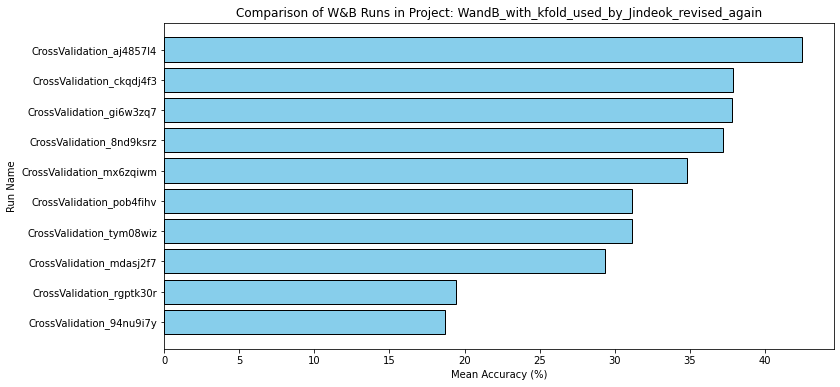

In [27]:
project_name = "WandB_with_kfold_used_by_Jindeok_revised_again"  # 비교하려는 W&B 프로젝트 이름
comparison_df = compare_wandb_runs(project_name)